# Baixando e Instalando Bibliotecas e Base de Dados para o Estudo de Caso.
***

In [ ]:
!pip install --upgrade pip
!sudo apt install libffi-dev
!sudo pip install PySUS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 17.6 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  libffi-dev
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 156 kB of archives.
After this operation, 362 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libffi-dev amd64 3.2.1-8 [156 kB]
Fetched 156 kB in 0s (2,054 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog b

In [ ]:
from pysus.online_data.sinasc import download, get_available_years # Base de Dados
import pysus
import matplotlib.pyplot as plt# Biblioteca de gráficos
import matplotlib
import seaborn as sns# Biblioteca de gráficos
import pandas as pd # Biblioteca de gerencaimento de tabeals
import numpy as np # Biblioteca de Vetores
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures # Biblioteca para tratameto de objetos
from sklearn.impute import SimpleImputer # Completar valores faltantes da tabela
from sklearn.compose import ColumnTransformer # Transormador de Colunas do Sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from google.colab import drive # Biblioteca para acessar o drive
from scipy import stats # Biblioteca para Estatística

drive.mount('/content/drive')
pd.set_option("display.max_columns", None) # Configurand para mostrar todas as colunas

Mounted at /content/drive


#Análise de Dados
***

## Verificando Anos Válidos para Análise

A biblioteca pysus disponibilisa dadosde 1994 até 2020 de SP

In [ ]:
get_available_years('BR')

['DNBR2014.dbc', 'DNBR2015.dbc', 'DNBR2016.dbc', 'DNBR2017.dbc']

## Convertendo data de .DCB para .csv

Convertendo .DCB para .csv o tamanho dos arquivos reuz consideravelmente, e colocando-os no Google Drive, os mesmos podem ser acessádos facilmente.

In [ ]:

anos = np.arange(2010, 2021)
for ano in anos:
  path = '/content/drive/MyDrive/SINASC/Python_Notebooks/Data/SP/SP_' + str(ano) + '.csv'
  df = pd.read_csv(path)
  print(ano, ' ', len(df.columns))

df = None


## Escolhendo as Colunas para Análise


Inicialmente serão obtidos os dados de SP em 2010 até 2020, como a partir desse ano foram coletadas mais colunas(56) para avaliação na base de dados.
O prósito desta análise é relacionar colunas com informações da mãe com a forma de parto(normal ou cesário). Por isso algumas como CEP do município, ID do hospital e colunas relacionadas não serão abordadas.

In [ ]:
for i in np.arange(2010, 2020):
  SP = pd.read_csv(f'/content/drive/MyDrive/SINASC/Data/SP/SP_{i}.csv').apply(pd.to_numeric, errors='ignore')
  SP = SP.replace(np.nan, 9)
  try:
    SP['ESCMAE2010']
    print(i)
  except:
    print()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)




2012


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (45) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


2013


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


2014
2015
2016
2017
2018
2019


## Filtrando e Selecionando Colunas Sócio Economicas


Inicialmete é feita a suposição que exste correlação entre índices socio economicos com a via de parto utilizado. Assim foram selecionádas colunas socio economicas da base de dados.

As colunas categóricas desta base de dados, usando o número '9.0' para representar valores faltantes, trocando estes valores é possível ter maior noção de quantos dados existem nesta base de dados

In [ ]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.width', 1000)

nomes_colunas = np.array(['PARTO', 'PESO', 
                          'GESTACAO', 'ESCMAE2010',
                          'ESTCIVMAE', 'RACACORMAE', 
                          'IDADEMAE',  'IDADEPAI', 
                          'QTDGESTANT', 'QTDPARTNOR', 
                          'QTDPARTCES', 'QTDFILVIVO', 
                          'QTDFILMORT'])


descrição_colunas = np.array(['Via de parto', 'Peso do filho ao nascer em gramas',
                      'Semanas de gestação', 'Escolaridade da mãe', 
                      'Estado civil da mãe', 'Raça da mãe', 
                      'Idade da Mãe', 'Idade do Pai',
                      'Quantidade de gestações', 'Quantidade de partos normais',
                      'Quantidade de parto cesáreos', 'Quantidade de filhos vivos',
                      'Quantidade de filhos Mortos', ])



dominio_colunas = np.array(['1– Vaginal; 2– Cesário; 9– Ignorado.', 'Números real', 
                            '1– Menos de 22 semanas; 2– 22 a 27 semanas; 3– 28 a 31 semanas; 4– 32 a 36 semanas; 5– 37 a 41 semanas; 6– 42 semanas e mais; 9– Ignorado.', '0 – Sem escolaridade; 1 – Fundamental I (1a a 4a série); 2 – Fundamental II (5a a 8a série); 3 –Médio (antigo 2o Grau); 4 – Superior incompleto;5 – Superior completo; 9 – Ignorado',
                            '1– Solteira; 2– Casada; 3– Viúva; 4– Separada judicialmente/divorciada; 5– Uniãoestável; 9– Ignorada', '1– Branca; 2– Preta; 3– Amarela; 4– Parda; 5– Indígena',
                            'Número inteiro', 'Número inteiro', 
                            'Número inteiro', 'Número inteiro', 
                            'Número inteiro', 'Número inteiro', 
                            'Número inteiro'])

df_descrição = pd.DataFrame({'Nome': nomes_colunas, 'Descrição': descrição_colunas, 'Domínio': dominio_colunas})


df_descrição.to_csv('descrição.csv')
df_descrição

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,Nome,Descrição,Domínio
0,PARTO,Via de parto,1– Vaginal; 2– Cesário; 9– Ignorado.
1,PESO,Peso do filho ao nascer em gramas,Números real
2,GESTACAO,Semanas de gestação,1– Menos de 22 semanas; 2– 22 a 27 semanas; 3– 28 a 31 semanas; 4– 32 a 36 semanas; 5– 37 a 41 semanas; 6– 42 semanas e mais; 9– Ignorado.
3,ESCMAE2010,Escolaridade da mãe,0 – Sem escolaridade; 1 – Fundamental I (1a a 4a série); 2 – Fundamental II (5a a 8a série); 3 –Médio (antigo 2o Grau); 4 – Superior incompleto;5 – Superior completo; 9 – Ignorado
4,ESTCIVMAE,Estado civil da mãe,1– Solteira; 2– Casada; 3– Viúva; 4– Separada judicialmente/divorciada; 5– Uniãoestável; 9– Ignorada
5,RACACORMAE,Raça da mãe,1– Branca; 2– Preta; 3– Amarela; 4– Parda; 5– Indígena
6,IDADEMAE,Idade da Mãe,Número inteiro
7,IDADEPAI,Idade do Pai,Número inteiro
8,QTDGESTANT,Quantidade de gestações,Número inteiro
9,QTDPARTNOR,Quantidade de partos normais,Número inteiro


## Gráficos para Melhor Visialização dos Dados



In [ ]:

# import required module
import os
# assign directory
directory = '/content/drive/Shareddrives/Data/DATA/'
 
# iterate over files in
# that directory
lista = []
for filename in os.listdir(directory):
  if filename != ('BRASIL' or 'RA'):
    '''path = f'{directory}{filename}/{filename}_2011.csv'
    lista.append(pd.read_csv(path))
    print(path)'''
    print(filename)
print(lista)

AM
AP
RS
SC
PR
SP
MG
RJ
ES
MT
MS
GO
BA
AL
PE
CE
MA
SE
DF
PA
RR
RA
PI
RN
RO
TO
AC
PB
[]


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (45) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


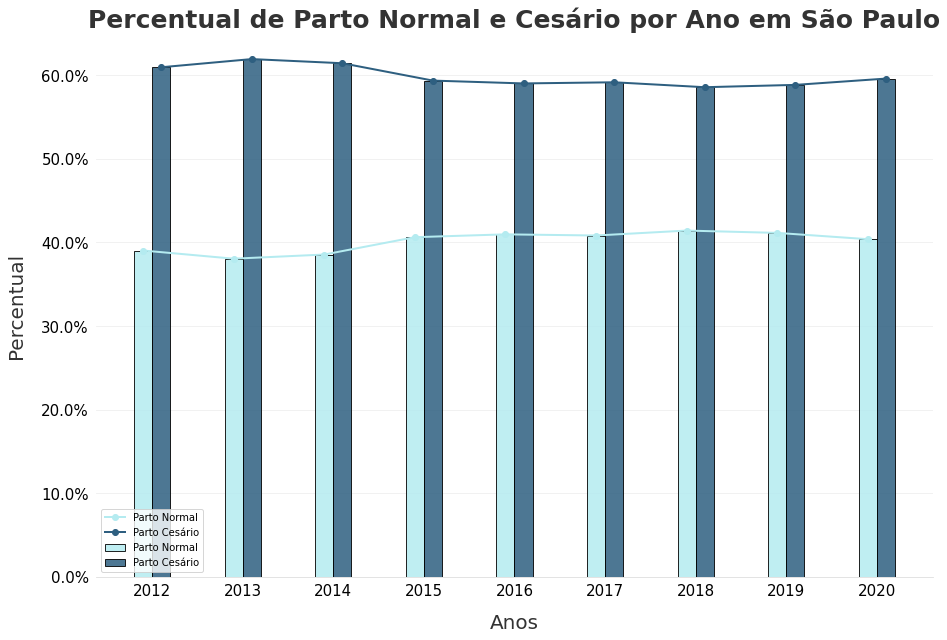

In [ ]:

normal = []
cesario = []
for ano in np.arange(2012, 2021):
  df = pd.read_csv(f'//content/drive/Shareddrives/Data/DATA/SP/SP_{ano}.csv').apply(pd.to_numeric, errors='ignore')
  df = df['PARTO'].replace(np.nan, 9.0)
  parto_ano = df.value_counts()
  normal.append(parto_ano[1.0])
  cesario.append(parto_ano[2.0])

normal = np.array(normal)
cesario = np.array(cesario)

var     = np.arange(2012, 2021)
fig, ax  = plt.subplots(figsize=(15, 10))
width   = 0.2
ind     = np.arange(len(normal))
graph1  = ax.plot(var - width/2, normal / (normal+cesario), color='#B4EBF0', label='Parto Normal', linewidth=2, marker ='o')
graph2  = ax.bar(var - width/2, normal / (normal+cesario), width, color='#B4EBF0', label='Parto Normal', alpha=0.85, edgecolor='black')
graph3  = ax.plot(var + width/2, cesario / (normal+cesario), color='#2E5F80', label='Parto Cesário', linewidth=2, marker ='o')
graph4  = ax.bar(var + width/2, cesario / (normal+cesario), width, color='#2E5F80', label='Parto Cesário', alpha=0.85, edgecolor='black')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)

ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
plt.xticks(var, fontsize=15 )
plt.yticks( fontsize=15 )
ax.set_yticklabels([ '0.0%', '10.0%', '20.0%', '30.0%', '40.0%', '50.0%', '60.0%'])


ax.set_title(f'Percentual de Parto Normal e Cesário por Ano em São Paulo', fontsize=25, color='#333333', weight='bold')
ax.set_xlabel('Anos', labelpad=15, color='#333333', fontsize=20)
ax.set_ylabel('Percentual', labelpad=15, color='#333333', fontsize=20)
ax.legend()
plt.savefig("SP_Anos.png", transparent=True)
plt.show()

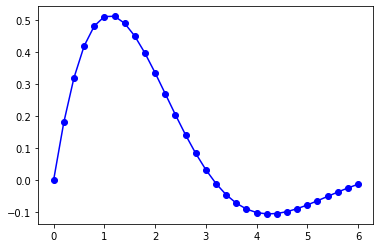

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Sample data points
x = np.linspace(0,6,31)
y = np.exp(-0.5*x) * np.sin(x)
# Plotting
plt.plot(x, y, 'bo-')
# Saving the figure with transparent background
plt.savefig('figure.png', transparent=True)

In [ ]:
import matplotlib.animation as animation

var     = np.arange(2010, 2021)
fig, ax  = plt.subplots(figsize=(15, 10))
width   = 0.2
ind     = np.arange(len(normal))
graph1  = ax.plot(var - width/2, normal / (normal+cesario), color='#B4EBF0', label='Parto Normal', linewidth=2, marker ='o')
graph2  = ax.bar(var - width/2, normal / (normal+cesario), width, color='#B4EBF0', label='Parto Normal', alpha=1, edgecolor='black')
graph3  = ax.plot(var + width/2, cesario / (normal+cesario), color='#2E5F80', label='Parto Cesário', linewidth=2, marker ='o')
graph4  = ax.bar(var + width/2, cesario / (normal+cesario), width, color='#2E5F80', label='Parto Cesário', alpha=1, edgecolor='black')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)

ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
plt.xticks(var, fontsize=15 )
plt.yticks( fontsize=15 )
ax.set_yticklabels([ '0.0%', '10.0%', '20.0%', '30.0%', '40.0%', '50.0%', '60.0%'])


ax.set_title(f'Taxa de Parto Normal e Cesário por Ano', fontsize=25, color='#333333', weight='bold')
ax.set_xlabel('Anos', labelpad=15, color='#333333', fontsize=20)
ax.set_ylabel('Ocorrência', labelpad=15, color='#333333', fontsize=20)
ax.legend()
plt.show()

1 - Via de parto por semana de gestação.

2 - Adicionar análise do Brasil todo, Ceara e São Paulo.

3 - Gráficos.

4 - ML para predição do Peso(Classificação e Regressão) e Prematuridade(Classificação e Regressão) com somente variáveis vistas antes do parto:

    - DTULTMENST
    - MESPRENAT
    - CONSULTAS
    - GRAVIDEZ
    - STCESPARTO
    - SEMAGESTAC

5 - Um csv de 2011 até 2021 Sudeste.

In [ ]:
"""
colunas_categoricas = ['TPNASCASSI', 'PARTO', 'ESCMAE2010', 'ESTCIVMAE', 
                       'RACACORMAE', 'MESPRENAT', 'CONSULTAS', 
                       'GRAVIDEZ', 'STTRABPART']

colunas_numericas = ['PESO', 'SEMAGESTAC',  'DTULTMENST', 'IDADEMAE', 
                     'QTDGESTANT', 'QTDPARTNOR', 'QTDPARTCES', 'QTDFILVIVO', 
                     'QTDFILMORT']

colunas_dummies = ['TPNASCASSI', 'ESCMAE2010', 'ESTCIVMAE', 'RACACORMAE', 
                   'MESPRENAT', 'CONSULTAS', 'GRAVIDEZ']

todas_colunas = ['TPNASCASSI', 'PARTO', 'ESCMAE2010', 'ESTCIVMAE', 'RACACORMAE', 'MESPRENAT', 
                'CONSULTAS', 'PESO', 'SEMAGESTAC', 'GRAVIDEZ', 'STTRABPART', 'DTULTMENST'
                ,'IDADEMAE', 'QTDGESTANT', 'QTDPARTNOR', 'QTDPARTCES', 
               'QTDFILVIVO', 'QTDFILMORT']
"""


colunas_categoricas = ['TPNASCASSI', 'PARTO', 'ESCMAE2010', 'ESTCIVMAE', 
                       'RACACORMAE', 'MESPRENAT', 'CONSULTAS', 
                       'GRAVIDEZ', 'STTRABPART']

colunas_numericas = ['PESO', 'SEMAGESTAC',  'DTULTMENST', 'IDADEMAE', 
                     'QTDGESTANT', 'QTDPARTNOR', 'QTDPARTCES', 'QTDFILVIVO', 
                     'QTDFILMORT']

colunas_dummies = ['TPNASCASSI', 'ESCMAE2010', 'ESTCIVMAE', 'RACACORMAE', 
                   'MESPRENAT', 'CONSULTAS', 'GRAVIDEZ']

todas_colunas = ['TPNASCASSI', 'PARTO', 'ESCMAE2010', 'ESTCIVMAE', 'RACACORMAE', 'MESPRENAT', 
                'CONSULTAS', 'PESO', 'SEMAGESTAC', 'GRAVIDEZ', 'STTRABPART', 'DTULTMENST'
                ,'IDADEMAE', 'QTDGESTANT', 'QTDPARTNOR', 'QTDPARTCES', 
               'QTDFILVIVO', 'QTDFILMORT']
selecao_colunas = ['TPNASCASSI', 'ESCMAE2010', 'ESTCIVMAE', 
                       'RACACORMAE', 'CONSULTAS', 
                       'GRAVIDEZ',]
 
def criarColunaPrematuro(df):
  if df['SEMAGESTAC'] >= 40:
    return 0
  elif df['SEMAGESTAC'] < 40:
    return 1

def criarColunaPeso(df):
  if df['PESO'] >= 2500.0:
    return 0
  elif df['PESO'] < 2500.0:
    return 1


SP = pd.read_csv(f'/content/drive/Shareddrives/Data/DATA/SP/SP_2020.csv').apply(pd.to_numeric, errors='ignore')
SP['PARTO'] = SP['PARTO'].replace({1.0:1.0, 2.0:0.0})
SP['PARTO'] = SP['PARTO'].replace(9.0, np.nan)
SP['MESPRENAT'].replace(99.0, np.nan)
SP['STTRABPART'] = SP['STTRABPART'].replace({1.0:1.0, 2.0:0.0})
SP["NASCPREMAT"] = SP.apply(lambda row: criarColunaPrematuro(row), axis=1)
SP["ABAIXOPESO"] = SP.apply(lambda row: criarColunaPeso(row), axis=1)
SP

,Unnamed: 0,ORIGEM,CODESTAB,CODMUNNASC,LOCNASC,IDADEMAE,ESTCIVMAE,ESCMAE,CODOCUPMAE,QTDFILVIVO,QTDFILMORT,CODMUNRES,GESTACAO,GRAVIDEZ,PARTO,CONSULTAS,DTNASC,HORANASC,SEXO,APGAR1,APGAR5,RACACOR,PESO,IDANOMAL,DTCADASTRO,CODANOMAL,NUMEROLOTE,VERSAOSIST,DTRECEBIM,DIFDATA,DTRECORIGA,NATURALMAE,CODMUNNATU,CODUFNATU,ESCMAE2010,SERIESCMAE,DTNASCMAE,RACACORMAE,QTDGESTANT,QTDPARTNOR,QTDPARTCES,IDADEPAI,DTULTMENST,SEMAGESTAC,TPMETESTIM,CONSPRENAT,MESPRENAT,TPAPRESENT,STTRABPART,STCESPARTO,TPNASCASSI,TPFUNCRESP,TPDOCRESP,DTDECLARAC,ESCMAEAGR1,STDNEPIDEM,STDNNOVA,CODPAISRES,TPROBSON,PARIDADE,KOTELCHUCK,CONTADOR,NASCPREMAT,ABAIXOPESO
0,0,1,2330830.0,150060,1,24,NaN,4.0,351305.0,0.0,0.0,350950,5.0,1.0,1.0,4.0,30042020,1539.0,1,9.0,10.0,NaN,3850.0,2.0,5052020,NaN,20210023,3.2.01,5052021.0,370,NaN,NaN,NaN,NaN,3.0,NaN,29011996.0,NaN,0.0,0.0,0.0,NaN,NaN,40.0,9.0,12.0,2.0,1.0,0.0,3.0,2.0,5.0,0.0,30042020.0,12.0,0,1,1,1,0,5,68412,0.0,0.0
1,1,1,2418657.0,150180,1,24,1.0,4.0,999992.0,0.0,1.0,354140,5.0,1.0,1.0,3.0,19012020,2044.0,1,8.0,9.0,4.0,3660.0,2.0,23012020,NaN,20200006,3.2.02,30012020.0,11,NaN,815.0,150180.0,15.0,3.0,3.0,25121995.0,4.0,1.0,0.0,0.0,NaN,8042019.0,40.0,8.0,6.0,3.0,1.0,0.0,3.0,2.0,5.0,4.0,19012020.0,6.0,0,1,1,3,1,4,89457,0.0,0.0
2,2,1,NaN,150360,3,30,5.0,5.0,999992.0,0.0,0.0,354870,5.0,1.0,1.0,3.0,19012020,7.0,1,NaN,NaN,1.0,3200.0,2.0,22012020,NaN,20200006,3.2.01,24012020.0,5,NaN,843.0,430770.0,43.0,5.0,NaN,10061989.0,1.0,0.0,0.0,0.0,NaN,NaN,39.0,1.0,6.0,6.0,1.0,0.0,3.0,2.0,2.0,3.0,21012020.0,8.0,0,1,1,1,0,2,100618,1.0,0.0
3,3,1,2755165.0,170210,1,34,1.0,4.0,999992.0,0.0,0.0,351060,5.0,1.0,0.0,3.0,11022020,2144.0,2,8.0,9.0,4.0,2625.0,2.0,12022020,NaN,20200007,3.2.00,17022020.0,6,NaN,817.0,170382.0,17.0,3.0,3.0,20051985.0,4.0,0.0,0.0,0.0,NaN,NaN,39.0,2.0,4.0,5.0,1.0,0.0,2.0,1.0,5.0,5.0,12022020.0,6.0,0,1,1,1,0,2,138416,1.0,0.0
4,4,1,2755157.0,172100,1,27,1.0,4.0,999992.0,2.0,0.0,354980,5.0,1.0,0.0,3.0,22012020,1659.0,2,6.0,9.0,4.0,3326.0,2.0,29012020,NaN,20200005,3.2.00,3022020.0,12,NaN,817.0,170950.0,17.0,2.0,8.0,18071992.0,4.0,2.0,0.0,2.0,NaN,NaN,39.0,9.0,6.0,1.0,1.0,0.0,1.0,1.0,NaN,3.0,22012020.0,4.0,0,1,1,5,1,4,146057,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552305,552305,2,2688433.0,350760,1,21,1.0,4.0,999992.0,1.0,0.0,350760,5.0,1.0,0.0,4.0,1122020,1720.0,1,9.0,10.0,1.0,3620.0,2.0,3122020,NaN,20200050,3.2.01,NaN,2,NaN,835.0,350760.0,35.0,3.0,3.0,19031999.0,1.0,1.0,0.0,1.0,26.0,NaN,38.0,2.0,8.0,5.0,1.0,0.0,1.0,1.0,2.0,3.0,1122020.0,6.0,0,1,1,5,1,2,2730141,1.0,0.0
552306,552306,2,2688433.0,350760,1,34,2.0,5.0,234505.0,0.0,2.0,355495,5.0,1.0,0.0,4.0,1122020,1935.0,1,8.0,10.0,1.0,3240.0,2.0,3122020,NaN,20200050,3.2.01,NaN,2,NaN,835.0,350760.0,35.0,5.0,NaN,27011986.0,1.0,2.0,0.0,0.0,38.0,3032020.0,39.0,8.0,12.0,1.0,2.0,0.0,1.0,1.0,2.0,4.0,1122020.0,8.0,0,1,1,7,1,5,2730142,1.0,0.0
552307,552307,2,2688433.0,350760,1,23,1.0,4.0,999992.0,2.0,0.0,350760,5.0,1.0,0.0,3.0,1122020,2334.0,2,9.0,10.0,1.0,3345.0,2.0,3122020,NaN,20200050,3.2.01,NaN,2,NaN,835.0,350410.0,35.0,3.0,1.0,4071997.0,1.0,2.0,0.0,2.0,27.0,NaN,39.0,2.0,5.0,4.0,1.0,0.0,1.0,1.0,2.0,3.0,2122020.0,5.0,0,1,1,5,1,2,2730143,1.0,0.0
552308,552308,2,3425398.0,420200,1,22,1.0,4.0,999992.0,1.0,0.0,355030,5.0,1.0,0.0,4.0,30052020,1240.0,1,8.0,10.0,1.0,3905.0,2.0,10062020,NaN,20200024,3.2.02,NaN,11,NaN,811.0,110020.0,11.0,3.0,3.0,9081997.0,1.0,1.0,1.0,0.0,NaN,NaN,39.0,1.0,8.0,2.0,1.0,0.0,1.0,1.0,2.0,3.0,2062020.0,6.0,0,1,1,4,1,5,2730144,1.0,0.0


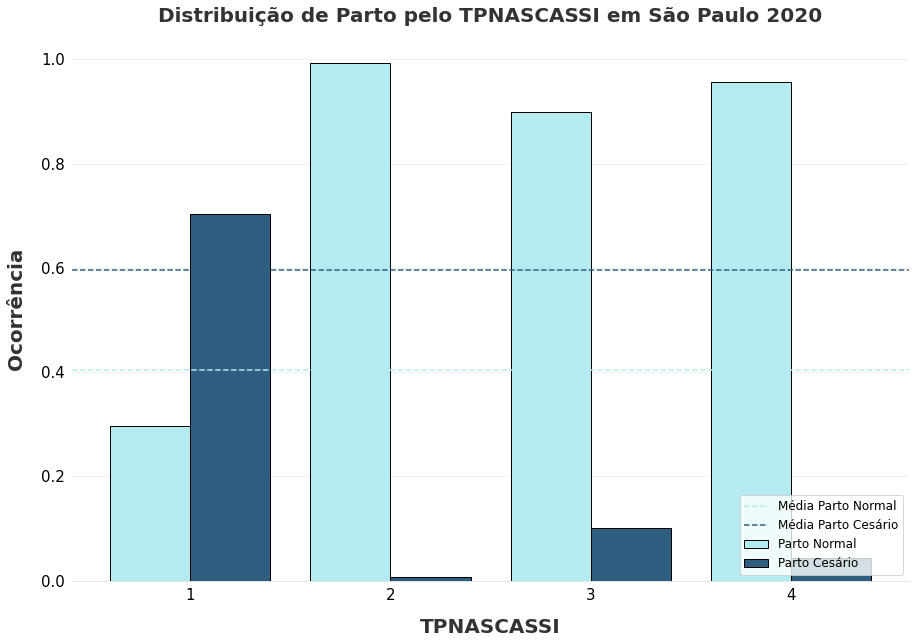

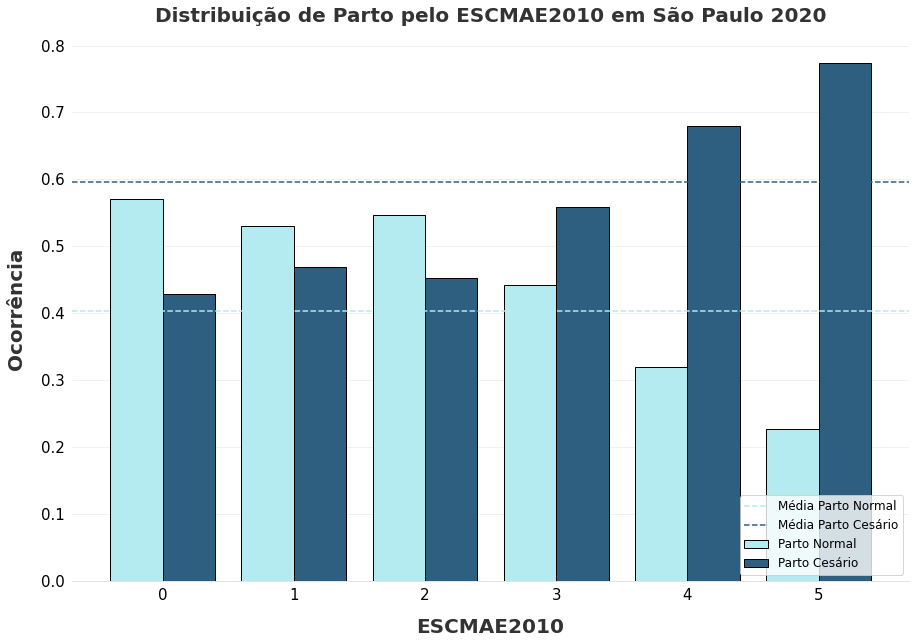

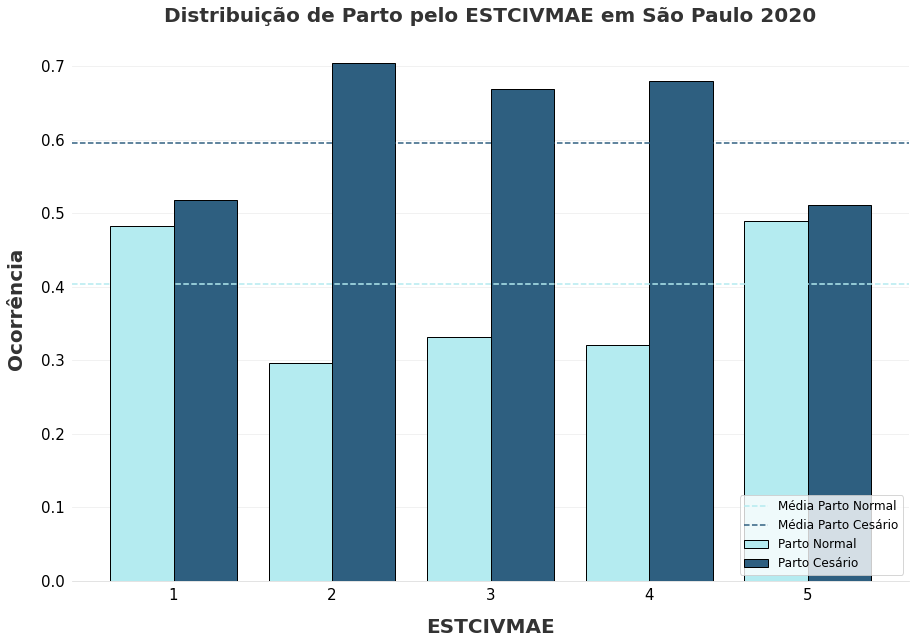

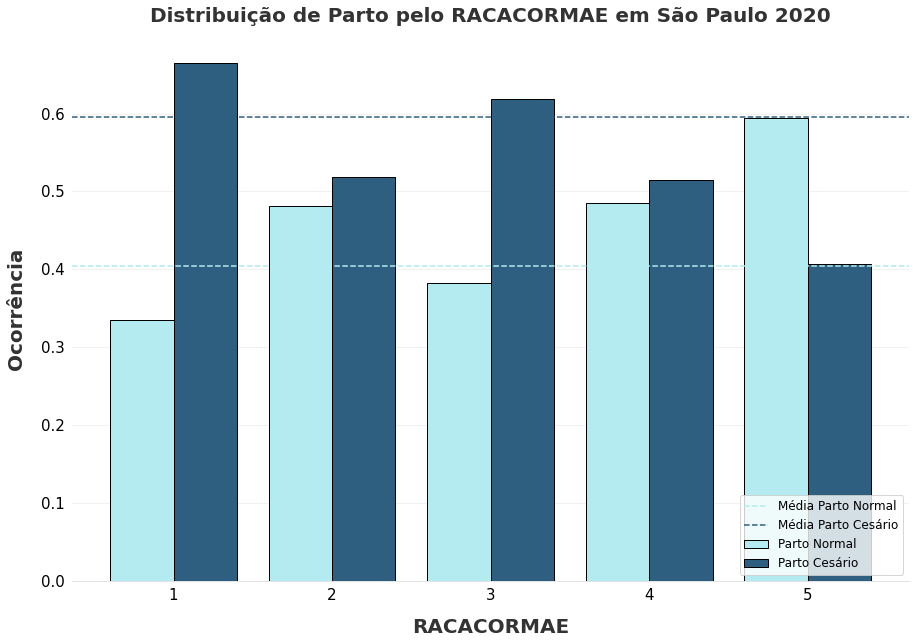

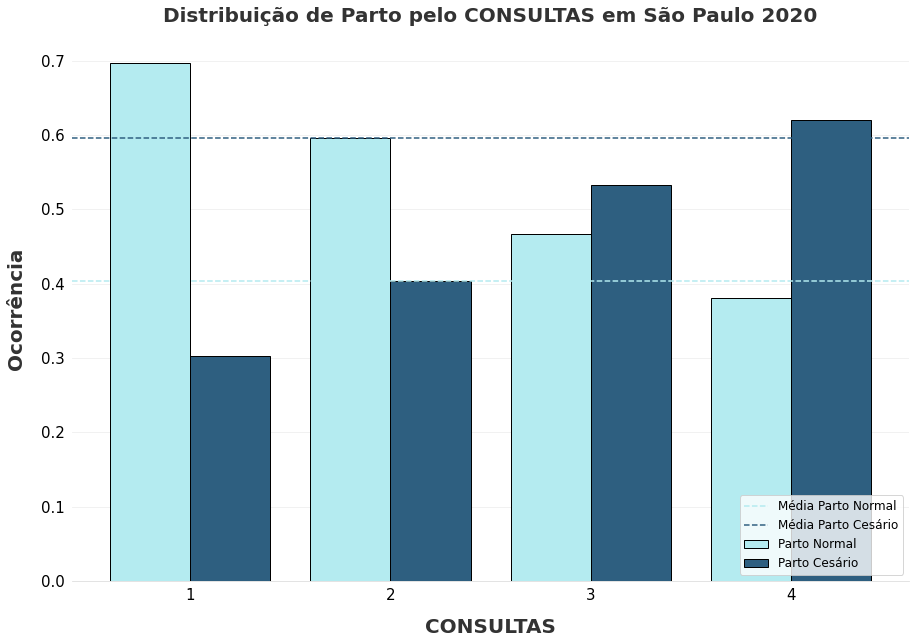

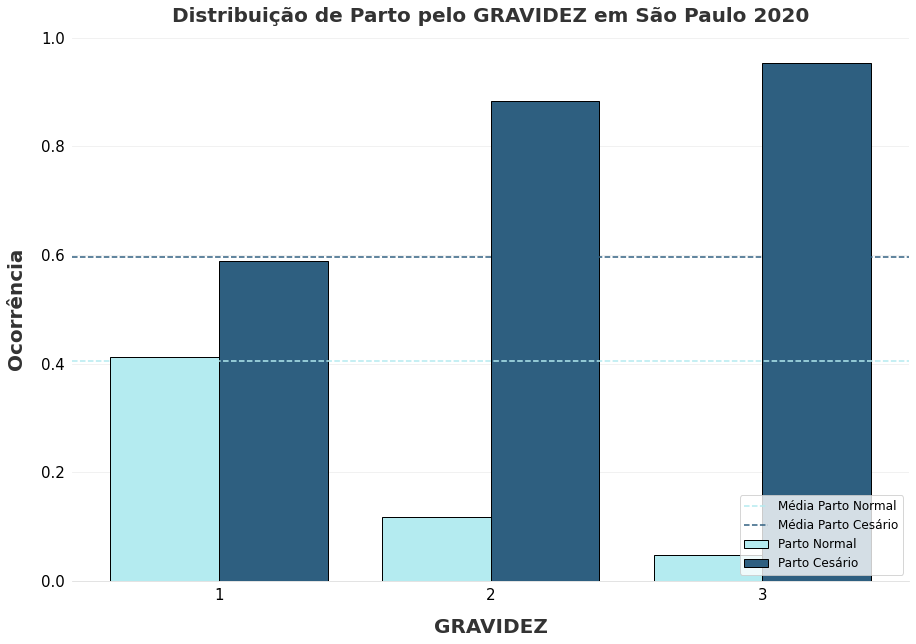

In [ ]:
for coluna in selecao_colunas:
  normal_prob = SP['PARTO'].value_counts()[1.0] / (SP['PARTO'].value_counts()[1.0] + SP['PARTO'].value_counts()[0.0])
  cesario_prob = SP['PARTO'].value_counts()[0.0] / (SP['PARTO'].value_counts()[1.0] + SP['PARTO'].value_counts()[0.0])
  SP[coluna] = SP[coluna].replace(9, np.nan)
  SP.dropna()
  crosstable = pd.crosstab(index=SP['PARTO'], columns=SP[coluna])
  var = crosstable.columns.to_numpy()
  normal = crosstable.iloc[1].to_numpy()
  cesario = crosstable.iloc[0].to_numpy()

  fig, ax = plt.subplots(figsize=(15, 10))
  width = 0.4
  ind = np.arange(len(normal))

  graph1 = ax.bar(var - width/2, normal / (normal + cesario), width, color='#B4EBF0', label='Parto Normal', edgecolor='black')
  graph2 = ax.bar(var + width/2, cesario / (normal + cesario), width, color='#2E5F80', label='Parto Cesário', edgecolor='black')
  graph3 = ax.axhline(y = normal_prob, color = '#B4EBF0', linestyle = '--', label='Média Parto Normal')
  graph4 = ax.axhline(y = cesario_prob, color = '#2E5F80', linestyle = '--', label='Média Parto Cesário')


  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_color('#DDDDDD')
  ax.tick_params(bottom=False, left=False)
  ax.set_axisbelow(True)
  ax.yaxis.grid(True, color='#EEEEEE')
  ax.xaxis.grid(False)
  ax.set_xticks(var)
  plt.xticks(fontsize=15 )
  plt.yticks(fontsize=15 )



  ax.set_title(f'Distribuição de Parto pelo {coluna} em São Paulo 2020', pad=15, color='#333333', weight='bold', fontsize=20)
  ax.set_xlabel(f'{coluna}', labelpad=15, color='#333333', fontsize=20, weight='bold')
  ax.set_ylabel('Ocorrência', labelpad=15, color='#333333', fontsize=20, weight='bold')
  ax.legend(fontsize = 12, loc='lower right')
  plt.show()
  #ax.figure.savefig('Escmae.png', transparent=True)
  print()

In [ ]:
anos =  np.arange(2012, 2021)
for ano in anos:
  SP = pd.read_csv(f'/content/drive/Shareddrives/Data/DATA/SP/SP_{ano}.csv').apply(pd.to_numeric, errors='ignore')
  SP['PARTO'] = SP['PARTO'].replace({1.0:1.0, 2.0:0.0})
  SP['PARTO'] = SP['PARTO'].replace(9.0, np.nan)
  SP['ESCMAE2010'] = SP['ESCMAE2010'].replace(9.0, np.nan)
  SP.dropna(axis=1)
  if anos[0] == ano:
    crosstable = pd.crosstab(index=SP['PARTO'], columns=SP['ESCMAE2010'])
  else:
    crosstable_ano = pd.crosstab(index=SP['PARTO'], columns=SP['ESCMAE2010'])
    crosstable = pd.concat([crosstable, crosstable_ano])

normal = crosstable.index == 1.0
cesareo = crosstable.index == 0.0
df_normal = pd.DataFrame()
df_cesareo = pd.DataFrame()
df['ANOS'] = anos
for coluna in crosstable.columns:
  df_normal[f'ESCMAE2010_{coluna}_NORMAL'] = crosstable[coluna][normal].to_numpy()
  df_cesareo[f'ESCMAE2010_{coluna}_CESAREO'] = crosstable[coluna][cesareo].to_numpy()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (45) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


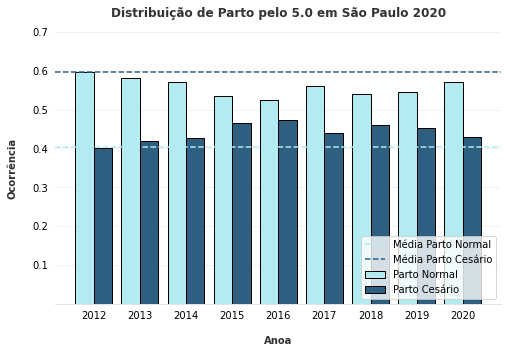

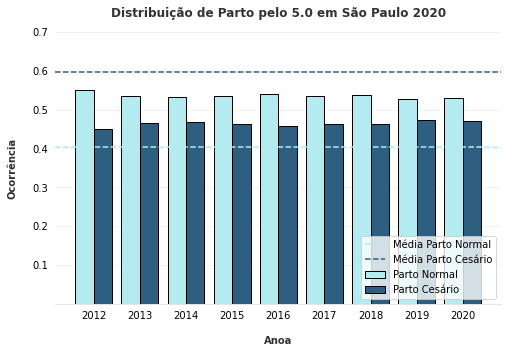

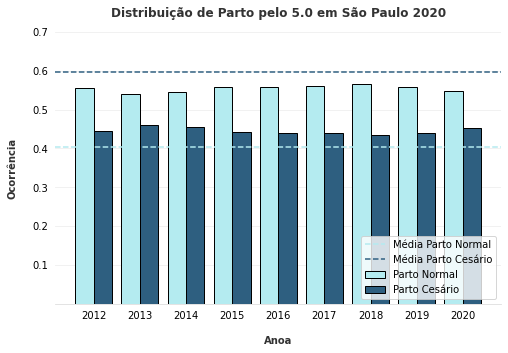

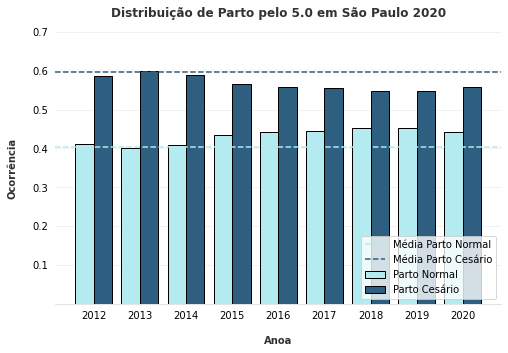

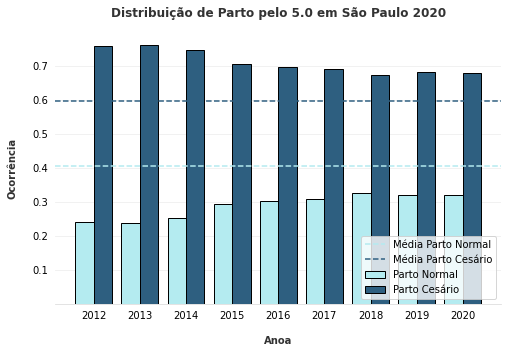

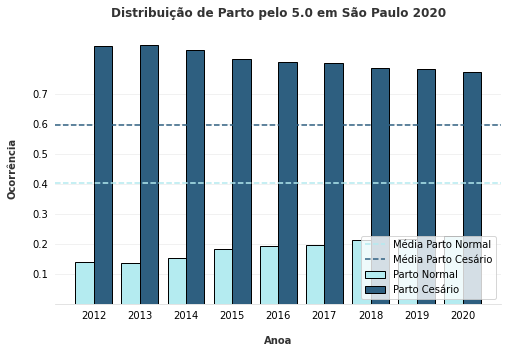

In [ ]:
for c in range(len(df_normal.columns)):
  fig, ax = plt.subplots(figsize=(8, 5))
  width = 0.4
  normal = df_normal.iloc[:, c]
  cesareo = df_cesareo.iloc[:, c]
  Y1 =  normal / (normal + cesareo)
  Y2 = cesareo / (normal + cesareo)
  graph1 = ax.bar(anos - width/2, Y1, width, color='#B4EBF0', label='Parto Normal', edgecolor='black')
  graph2 = ax.bar(anos + width/2, Y2, width, color='#2E5F80', label='Parto Cesário', edgecolor='black')
  graph3 = ax.axhline(y = normal_prob, color = '#B4EBF0', linestyle = '--', label='Média Parto Normal')
  graph4 = ax.axhline(y = cesario_prob, color = '#2E5F80', linestyle = '--', label='Média Parto Cesário')


  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_color('#DDDDDD')
  ax.tick_params(bottom=False, left=False)
  ax.set_axisbelow(True)
  ax.yaxis.grid(True, color='#EEEEEE')
  ax.xaxis.grid(False)
  ax.set_yticks(np.arange(0.1, 0.8, 0.1))
  ax.set_xticks(anos)
  plt.xticks()
  plt.yticks()

  ax.set_title(f'Distribuição de Parto pelo {coluna} em São Paulo 2020', pad=15, color='#333333', weight='bold')
  ax.set_xlabel(f'Anoa', labelpad=15, color='#333333',  weight='bold')
  ax.set_ylabel('Ocorrência', labelpad=15, color='#333333',  weight='bold')
  ax.legend(loc='lower right')
  plt.show()
  print()

In [ ]:
import plotly.express as px


df = px.data.stocks(indexed=True)-1
fig = px.area(df, facet_col="company", facet_col_wrap=2)
fig.show()

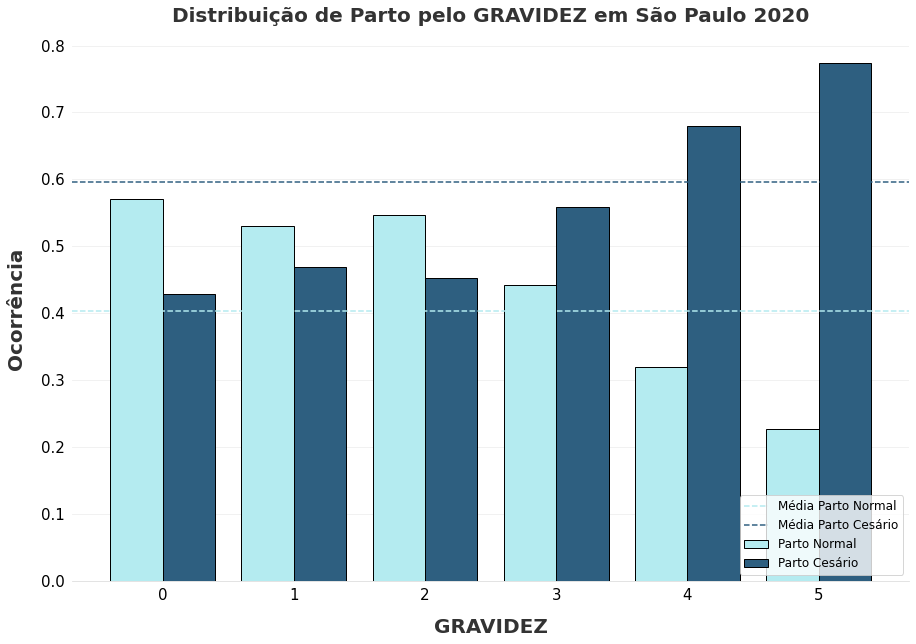

In [ ]:

crosstable = pd.crosstab(index=SP['PARTO'], columns=SP['ESCMAE2010'])
var = crosstable.columns.to_numpy()
normal = crosstable.iloc[1].to_numpy()
cesario = crosstable.iloc[0].to_numpy()

fig, ax = plt.subplots(figsize=(15, 10))
width = 0.4
ind = np.arange(len(normal))


Y1 =  normal / (normal + cesario)
Y2 = cesario / (normal + cesario)
graph1 = ax.bar(var - width/2, Y1, width, color='#B4EBF0', label='Parto Normal', edgecolor='black')
graph2 = ax.bar(var + width/2, Y2, width, color='#2E5F80', label='Parto Cesário', edgecolor='black')
graph3 = ax.axhline(y = normal_prob, color = '#B4EBF0', linestyle = '--', label='Média Parto Normal')
graph4 = ax.axhline(y = cesario_prob, color = '#2E5F80', linestyle = '--', label='Média Parto Cesário')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
ax.set_xticks(var)
plt.xticks(fontsize=15 )
plt.yticks(fontsize=15 )



ax.set_title(f'Distribuição de Parto pelo {coluna} em São Paulo 2020', pad=15, color='#333333', weight='bold', fontsize=20)
ax.set_xlabel(f'{coluna}', labelpad=15, color='#333333', fontsize=20, weight='bold')
ax.set_ylabel('Ocorrência', labelpad=15, color='#333333', fontsize=20, weight='bold')
ax.legend(fontsize = 12, loc='lower right')
plt.show()
#ax.figure.savefig('Escmae.png', transparent=True)
print()


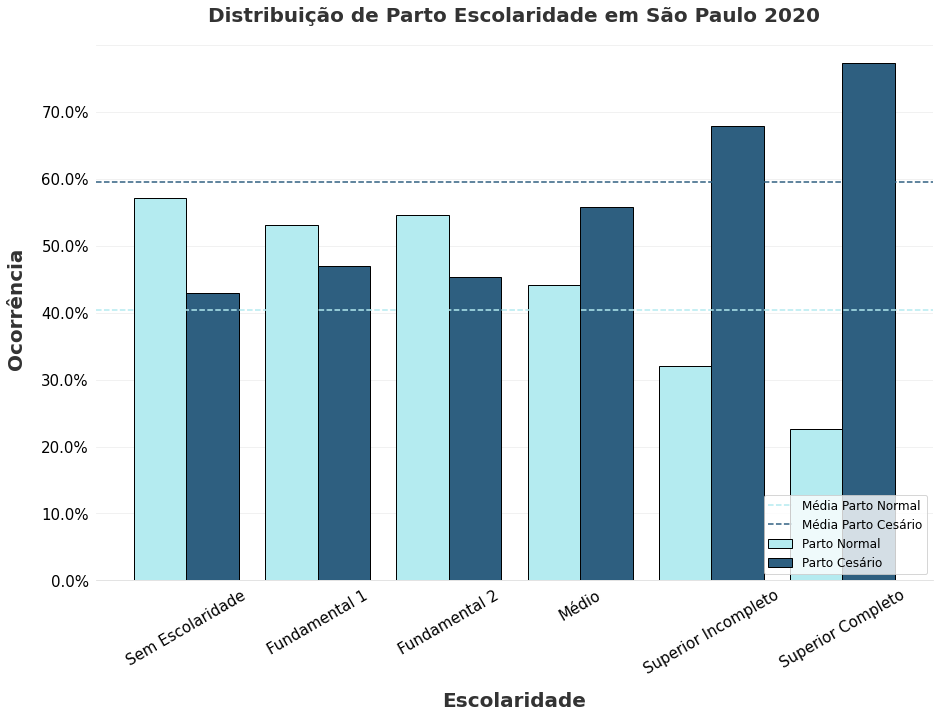

In [ ]:
normal_prob = SP['PARTO'].value_counts()[1.0] / (SP['PARTO'].value_counts()[1.0] + SP['PARTO'].value_counts()[2.0])
cesario_prob = SP['PARTO'].value_counts()[2.0] / (SP['PARTO'].value_counts()[1.0] + SP['PARTO'].value_counts()[2.0])


crosstable = pd.crosstab(index=SP['PARTO'], columns=SP['ESCMAE2010'])
var = crosstable.columns.to_numpy()
normal = crosstable.iloc[0].to_numpy()
cesario = crosstable.iloc[1].to_numpy()


fig, ax = plt.subplots(figsize=(15, 10))
width = 0.4
ind = np.arange(len(normal))

graph1 = ax.bar(var - width/2, normal / (normal + cesario), width, color='#B4EBF0', label='Parto Normal', edgecolor='black')
graph2 = ax.bar(var + width/2, cesario / (normal + cesario), width, color='#2E5F80', label='Parto Cesário', edgecolor='black')
graph3 = ax.axhline(y = normal_prob, color = '#B4EBF0', linestyle = '--', label='Média Parto Normal')
graph4 = ax.axhline(y = cesario_prob, color = '#2E5F80', linestyle = '--', label='Média Parto Cesário')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
ax.set_xticks(var)
ax.set_xticklabels(['Sem Escolaridade', 'Fundamental 1', 'Fundamental 2', 'Médio', 'Superior Incompleto', 'Superior Completo'], rotation=30)
ax.set_yticklabels([ '0.0%', '10.0%', '20.0%', '30.0%', '40.0%', '50.0%', '60.0%', '70.0%'])
plt.xticks(fontsize=15 )
plt.yticks(fontsize=15 )



ax.set_title(f'Distribuição de Parto Escolaridade em São Paulo 2020', pad=15, color='#333333', weight='bold', fontsize=20)
ax.set_xlabel('Escolaridade', labelpad=15, color='#333333', fontsize=20, weight='bold')
ax.set_ylabel('Ocorrência', labelpad=15, color='#333333', fontsize=20, weight='bold')
ax.legend(fontsize = 12, loc='lower right')
plt.show()
ax.figure.savefig('Escmae.png', transparent=True)

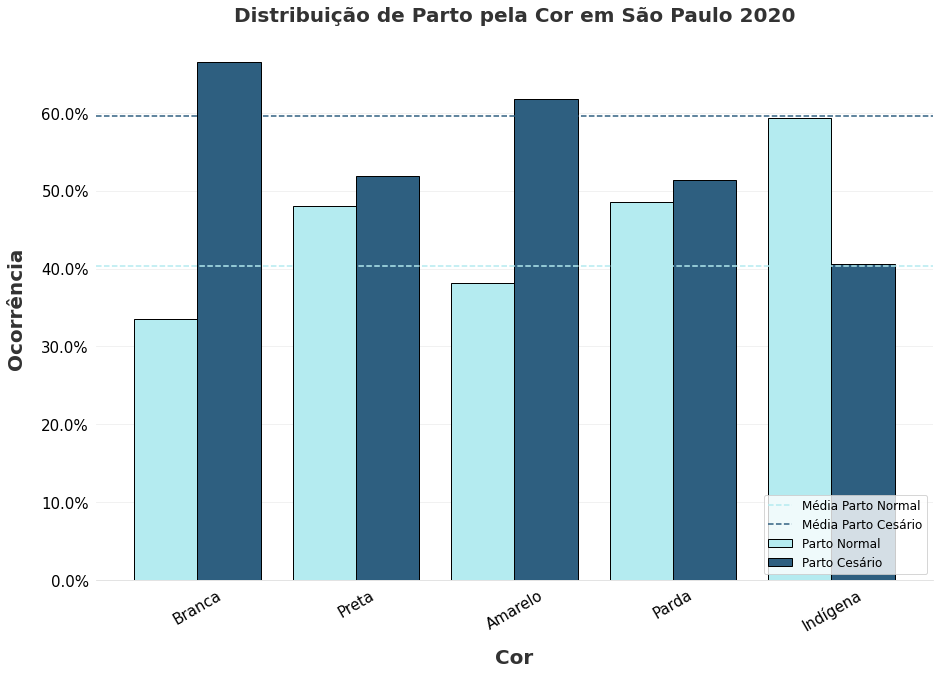

In [ ]:
normal_prob = SP['PARTO'].value_counts()[1.0] / (SP['PARTO'].value_counts()[1.0] + SP['PARTO'].value_counts()[2.0])
cesario_prob = SP['PARTO'].value_counts()[2.0] / (SP['PARTO'].value_counts()[1.0] + SP['PARTO'].value_counts()[2.0])


crosstable = pd.crosstab(index=SP['PARTO'], columns=SP['RACACORMAE'])
var = crosstable.columns.to_numpy()
normal = crosstable.iloc[0].to_numpy()
cesario = crosstable.iloc[1].to_numpy()


fig, ax = plt.subplots(figsize=(15, 10))
width = 0.4
ind = np.arange(len(normal))

graph1 = ax.bar(var - width/2, normal / (normal + cesario), width, color='#B4EBF0', label='Parto Normal', edgecolor='black')
graph2 = ax.bar(var + width/2, cesario / (normal + cesario), width, color='#2E5F80', label='Parto Cesário', edgecolor='black')
graph3 = ax.axhline(y = normal_prob, color = '#B4EBF0', linestyle = '--', label='Média Parto Normal')
graph4 = ax.axhline(y = cesario_prob, color = '#2E5F80', linestyle = '--', label='Média Parto Cesário')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
ax.set_xticks(var)
ax.set_xticklabels(['Branca', 'Preta', 'Amarelo', 'Parda', 'Indígena'], rotation = 30)
ax.set_yticklabels([ '0.0%', '10.0%', '20.0%', '30.0%', '40.0%', '50.0%', '60.0%', '70.0%'])
plt.xticks(fontsize=15 )
plt.yticks(fontsize=15 )



ax.set_title(f'Distribuição de Parto pela Cor em São Paulo 2020', pad=15, color='#333333', weight='bold', fontsize=20)
ax.set_xlabel('Cor', labelpad=15, color='#333333', fontsize=20, weight='bold')
ax.set_ylabel('Ocorrência', labelpad=15, color='#333333', fontsize=20, weight='bold')
ax.legend(fontsize = 12, loc='lower right')
plt.show()
ax.figure.savefig('Escmae.png', transparent=True)

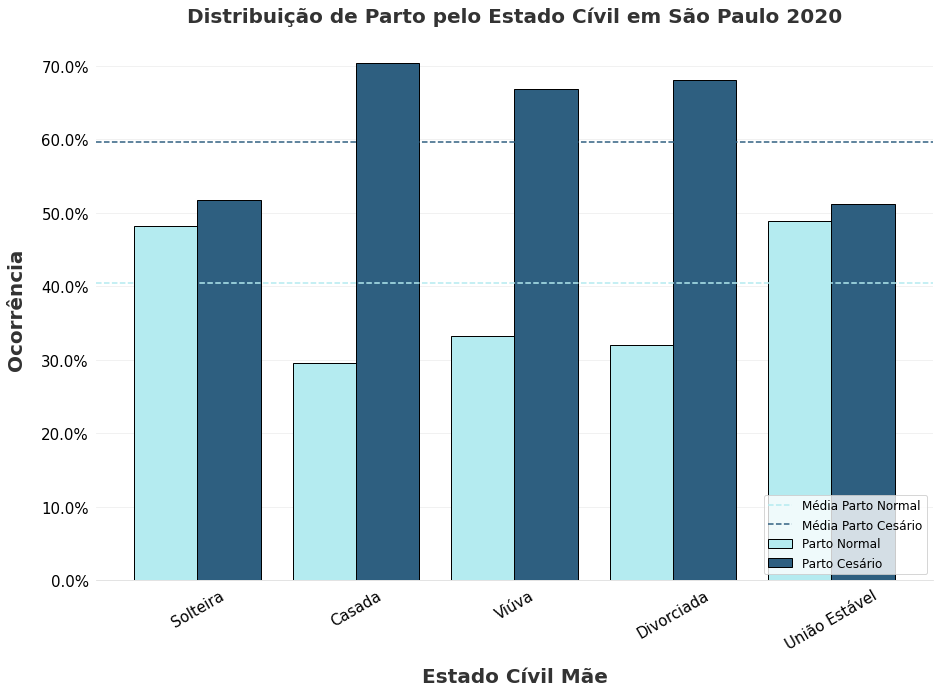

In [ ]:
normal_prob = SP['PARTO'].value_counts()[1.0] / (SP['PARTO'].value_counts()[1.0] + SP['PARTO'].value_counts()[2.0])
cesario_prob = SP['PARTO'].value_counts()[2.0] / (SP['PARTO'].value_counts()[1.0] + SP['PARTO'].value_counts()[2.0])


crosstable = pd.crosstab(index=SP['PARTO'], columns=SP['ESTCIVMAE'])
var = crosstable.columns.to_numpy()
normal = crosstable.iloc[0].to_numpy()
cesario = crosstable.iloc[1].to_numpy()


fig, ax = plt.subplots(figsize=(15, 10))
width = 0.4
ind = np.arange(len(normal))

graph1 = ax.bar(var - width/2, normal / (normal + cesario), width, color='#B4EBF0', label='Parto Normal', edgecolor='black')
graph2 = ax.bar(var + width/2, cesario / (normal + cesario), width, color='#2E5F80', label='Parto Cesário', edgecolor='black')
graph3 = ax.axhline(y = normal_prob, color = '#B4EBF0', linestyle = '--', label='Média Parto Normal')
graph4 = ax.axhline(y = cesario_prob, color = '#2E5F80', linestyle = '--', label='Média Parto Cesário')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
ax.set_xticks(var)
ax.set_xticklabels(['Solteira', 'Casada', 'Viúva', 'Divorciada', 'União Estável'], rotation = 30)
ax.set_yticklabels([ '0.0%', '10.0%', '20.0%', '30.0%', '40.0%', '50.0%', '60.0%', '70.0%'])
plt.xticks(fontsize=15 )
plt.yticks(fontsize=15 )



ax.set_title(f'Distribuição de Parto pelo Estado Cívil em São Paulo 2020', pad=15, color='#333333', weight='bold', fontsize=20)
ax.set_xlabel('Estado Cívil Mãe', labelpad=15, color='#333333', fontsize=20, weight='bold')
ax.set_ylabel('Ocorrência', labelpad=15, color='#333333', fontsize=20, weight='bold')
ax.legend(fontsize = 12, loc='lower right')
plt.show()
ax.figure.savefig('Escmae.png', transparent=True)

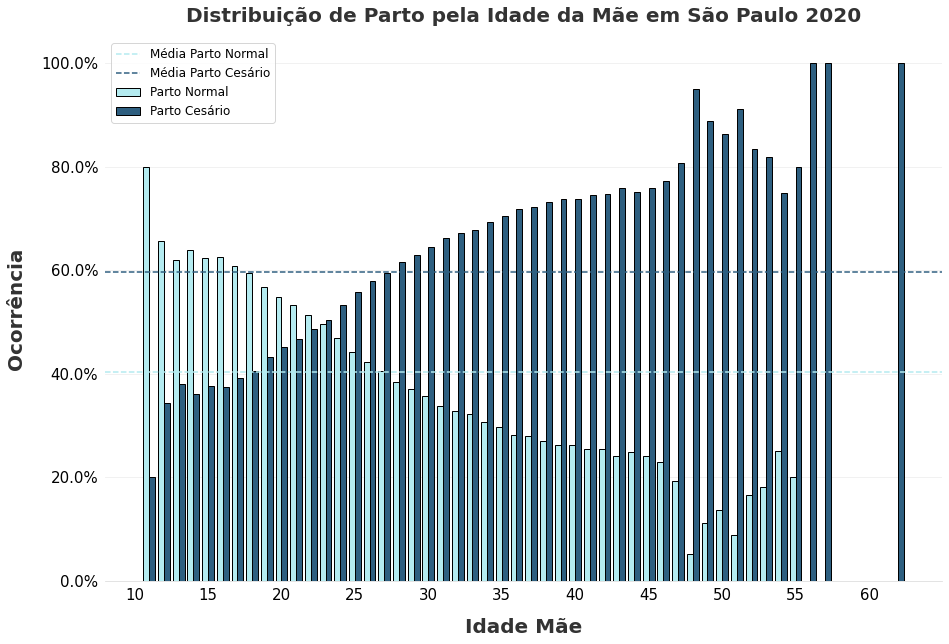

In [ ]:
normal_prob = SP['PARTO'].value_counts()[1.0] / (SP['PARTO'].value_counts()[1.0] + SP['PARTO'].value_counts()[2.0])
cesario_prob = SP['PARTO'].value_counts()[2.0] / (SP['PARTO'].value_counts()[1.0] + SP['PARTO'].value_counts()[2.0])

crosstable = pd.crosstab(index=SP['PARTO'], columns=SP['IDADEMAE'])
var = crosstable.columns.to_numpy()[:-1]
normal = crosstable.iloc[0].to_numpy()[:-1]
cesario = crosstable.iloc[1].to_numpy()[:-1]


fig, ax = plt.subplots(figsize=(15, 10))
width = 0.4

graph1 = ax.bar(var - width/2, normal / (normal + cesario), width, color='#B4EBF0', label='Parto Normal', edgecolor='black')
graph2 = ax.bar(var + width/2, cesario / (normal + cesario), width, color='#2E5F80', label='Parto Cesário', edgecolor='black')
graph3 = ax.axhline(y = normal_prob, color = '#B4EBF0', linestyle = '--', label='Média Parto Normal')
graph4 = ax.axhline(y = cesario_prob, color = '#2E5F80', linestyle = '--', label='Média Parto Cesário')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

ax.set_yticklabels([ '0.0%', '20.0%', '40.0%', '60.0%', '80.0%', '100.0%'])
plt.xticks(np.arange(10, 65, 5), fontsize=15 )
plt.yticks(fontsize=15 )



ax.set_title(f'Distribuição de Parto pela Idade da Mãe em São Paulo 2020', pad=15, color='#333333', weight='bold', fontsize=20)
ax.set_xlabel('Idade Mãe', labelpad=15, color='#333333', fontsize=20, weight='bold')
ax.set_ylabel('Ocorrência', labelpad=15, color='#333333', fontsize=20, weight='bold')
ax.legend(fontsize = 12)
plt.show()
ax.figure.savefig('Escmae.png', transparent=True)

In [ ]:

normal_prob = SP['PARTO'].value_counts()[1.0] / (SP['PARTO'].value_counts()[1.0] + SP['PARTO'].value_counts()[2.0])
cesario_prob = SP['PARTO'].value_counts()[2.0] / (SP['PARTO'].value_counts()[1.0] + SP['PARTO'].value_counts()[2.0])

for coluna in colunas_cat:
  crosstable = pd.crosstab(index=SP['PARTO'], columns=SP[coluna])
  var = crosstable.columns.to_numpy()[:-1]
  normal = crosstable.iloc[0].to_numpy()[:-1]
  cesario = crosstable.iloc[1].to_numpy()[:-1]


  fig, ax = plt.subplots(figsize=(15, 10))
  width = 0.4
  ind = np.arange(len(normal))
  
  graph1 = ax.bar(var - width/2, normal / (normal + cesario), width, color='lightgreen', label='Parto Normal', edgecolor='black', alpha=0.5)
  graph2 = ax.bar(var + width/2, cesario / (normal + cesario), width, color='salmon', label='Parto Cesário', edgecolor='black', alpha=0.5)
  graph3 = ax.axhline(y = normal_prob, color = 'lightgreen', linestyle = '--', label='Média Parto Normal')
  graph4 = ax.axhline(y = cesario_prob, color = 'salmon', linestyle = '--', label='Média Parto Cesário')


  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_color('#DDDDDD')
  ax.tick_params(bottom=False, left=False)
  ax.set_axisbelow(True)
  ax.yaxis.grid(True, color='#EEEEEE')
  ax.xaxis.grid(False)
  ax.set_xticks(var)

  ax.set_title(f'Distribuição de Parto Normal e Cesário por {coluna} em 2020', pad=15, color='#333333', weight='bold')
  ax.set_xlabel(coluna, labelpad=15, color='#333333')
  ax.set_ylabel('Ocorrência', labelpad=15, color='#333333')
  ax.legend()

In [ ]:
for coluna in colunas_num:
  crosstable = pd.crosstab(index=SP['PARTO'], columns=SP[coluna])
  var = crosstable.columns.to_numpy()[:-1]
  normal = crosstable.iloc[0].to_numpy()[:-1]
  cesario = crosstable.iloc[1].to_numpy()[:-1]

  


  fig, ax = plt.subplots(figsize=(15, 10))
  width = 0.4
  ind = np.arange(len(normal))
  
  graph1 = ax.bar(var - width/2, normal / (normal + cesario), width, color='lightgreen', label='Parto Normal', edgecolor='black', alpha=0.5)
  graph2 = ax.bar(var + width/2, cesario / (normal + cesario), width, color='salmon', label='Parto Cesário', edgecolor='black', alpha=0.5)
  graph3 = ax.axhline(y = normal_prob, color = 'lightgreen', linestyle = '--', label='Média Parto Normal')
  graph4 = ax.axhline(y = cesario_prob, color = 'salmon', linestyle = '--', label='Média Parto Cesário')


  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_color('#DDDDDD')
  ax.tick_params(bottom=False, left=False)
  ax.set_axisbelow(True)
  ax.yaxis.grid(True, color='#EEEEEE')
  ax.xaxis.grid(False)

  ax.set_title(f'Distribuição de Parto Normal e Cesário por {coluna} em 2020', pad=15, color='#333333', weight='bold')
  ax.set_xlabel(coluna, labelpad=15, color='#333333')
  ax.set_ylabel('Ocorrência', labelpad=15, color='#333333')
  ax.legend()

Slide 1: Serie Temporal (scatter) do % de partos vaginal e partos normais nos últimos 10 anos:
- SP, CE, BRA
1 - Serie Temporal  do % de partos vaginal e partos normais nos últimos 10 anos:
- SP, CE, BRA
Cristiano Torezzan21:07
1 - Serie Temporal  do % de partos cesarep e partos normais nos últimos 10 anos:
- SP, CE, BRA
1 - Serie Temporal  do % de partos cesáreo e partos normais nos últimos 10 anos:
- SP, CE, BRA
Cristiano Torezzan21:10
2 - Variáveis aderentes:
- ESCOLARIDADE
- IDADE MAE
- EST. CIVIL
- RACA/COR

3 - Investigar:
- PESO AO NASCER
- CONSULTAS
- APGAR

## Usando Testes de Hipótese para Verificar Correlação Entre as Coluas com a Via de Parto

Foram utilizados o teste qui-quadrado e V-Cramer para as colunas categóricas e ANOVA para as colunas numéricas.

In [ ]:
df_vcrammer = {'Nome':[], 'Parto Cesáreo':[], 'Parto Normal':[]}
for colum in colunas_cat:
  dummies = pd.get_dummies(SP[colum])
  num = 0.0
  for dummie in dummies:
    crostable = pd.crosstab(SP['PARTO'], dummies[dummie])
    chi2, p, dof, expected = stats.chi2_contingency(crostable)
    print('V-Cramer da coluna', colum)
    print(p)
    print('-'*100)

V-Cramer da coluna ESCMAE2010
1.2746089393119638e-13
----------------------------------------------------------------------------------------------------
V-Cramer da coluna ESCMAE2010
4.734318227875325e-102
----------------------------------------------------------------------------------------------------
V-Cramer da coluna ESCMAE2010
0.0
----------------------------------------------------------------------------------------------------
V-Cramer da coluna ESCMAE2010
0.0
----------------------------------------------------------------------------------------------------
V-Cramer da coluna ESCMAE2010
1.7107852717203296e-195
----------------------------------------------------------------------------------------------------
V-Cramer da coluna ESCMAE2010
0.0
----------------------------------------------------------------------------------------------------
V-Cramer da coluna ESTCIVMAE
0.0
---------------------------------------------------------------------------------------------------

In [ ]:
print('-'*100)
for coluna in colunas_num:
  crostab = pd.crosstab(SP['PARTO'], SP[coluna])
  F, p = stats.f_oneway(*(crostab[colum] for colum in crostab.columns))
  print(f'{coluna}\npvalue:{p}\nfvalue{F}')
  print('-'*100)

----------------------------------------------------------------------------------------------------
IDADEMAE
pvalue:8.286858601169701e-11
fvalue7.1735154347538765
----------------------------------------------------------------------------------------------------
IDADEPAI
pvalue:1.0478488962855827e-07
fvalue3.3738461443120196
----------------------------------------------------------------------------------------------------
QTDGESTANT
pvalue:6.6141037127955995e-12
fvalue19.181332319026097
----------------------------------------------------------------------------------------------------
QTDPARTNOR
pvalue:5.31274431017667e-05
fvalue4.8793292862955
----------------------------------------------------------------------------------------------------
QTDPARTCES
pvalue:1.2823951187792018e-09
fvalue20.66432441325609
----------------------------------------------------------------------------------------------------
QTDFILVIVO
pvalue:1.0895794505642687e-07
fvalue16.642028057448925
---------

## Resultados dos Testes de Hipóteses

Felizmete com todos ospvalue menores que 5%, as hipóteses nulas estão descartadas, como colunas selecionadas estão aparentemente correlacionadas com a via de parto, então as mesmas serão usadas nos possíveis algoritos de machine learning.

## Objetivo e Base de Dados

O objetivo finál deste estudo de caso é desenvollver um algoritmo treinado de machine learning para previsão da probabilidade de cada parto baseado em índices soxioeconomicos.
Como o SINASC disponibiliza o registro de múltiplos anos e cada tabela contém de 300 mil a 600 mil registros, utilizar a junção de todos os anos é inviável, pois o treinamento demoraria muito tempo. Más criando um dataframe com uma pequena parte de todas as tabelas, possívelmente será obtido a variabilidade de dados e um tempo de treinamento adequado.

Peso do bebe por via de parto


In [ ]:
colunas_categoricas = ['CODMUNRES', 'PARTO', 'ESCMAE2010', 'ESTCIVMAE', 
                       'RACACORMAE', 'MESPRENAT', 'CONSULTAS', 
                       'GRAVIDEZ', 'STTRABPART']

colunas_numericas = ['PESO', 'SEMAGESTAC',  'DTULTMENST', 'IDADEMAE', 
                     'QTDGESTANT', 'QTDPARTNOR', 'QTDPARTCES', 'QTDFILVIVO', 
                     'QTDFILMORT']

colunas_dummies = ['CODMUNRES', 'ESCMAE2010', 'ESTCIVMAE', 'RACACORMAE', 
                   'MESPRENAT', 'CONSULTAS', 'GRAVIDEZ']

todas_colunas = ['CODMUNRES', 'PARTO', 'ESCMAE2010', 'ESTCIVMAE', 'RACACORMAE', 'MESPRENAT', 
                'CONSULTAS', 'PESO', 'SEMAGESTAC', 'GRAVIDEZ', 'STTRABPART', 'DTULTMENST'
                ,'IDADEMAE', 'QTDGESTANT', 'QTDPARTNOR', 'QTDPARTCES', 
               'QTDFILVIVO', 'QTDFILMORT']


 

np.random.seed(0)


def criarColunaPrematuro(df):
  if df['SEMAGESTAC'] >= 40:
    return 0
  elif df['SEMAGESTAC'] < 40:
    return 1

def criarColunaPeso(df):
  if df['PESO'] >= 2500.0:
    return 0
  elif df['PESO'] < 2500.0:
    return 1


for ano in np.arange(2018, 2021):
  SP_ano =  pd.read_csv(f'/content/drive/MyDrive/SINASC/Data/SP/SP_{ano}.csv').apply(pd.to_numeric, errors='ignore')[todas_colunas]
  SP_ano[colunas_categoricas] = SP_ano[colunas_categoricas].replace(9.0, np.nan)
  SP_ano = SP_ano.dropna()
  index = np.random.randint(0, SP_ano.shape[0], 30000)
  if ano == 2018:
    SP = SP_ano.iloc[index, :]
  else:
    SP_ano = SP_ano.iloc[index, :]
    SP = pd.concat([SP, SP_ano])
  print('O ano ', ano, 'foi adionado com sucesso!')

SP['PARTO'] = SP['PARTO'].replace({1.0:1.0, 2.0:0.0})
SP['STTRABPART'] = SP['STTRABPART'].replace({1.0:1.0, 2.0:0.0})
SP = pd.get_dummies(SP, columns=colunas_dummies)
SP.to_csv('/content/drive/MyDrive/SINASC/Data/SP/SP_2012_2020.csv')
SP["NASCPREMAT"] = SP.apply(lambda row: criarColunaPrematuro(row), axis=1)
SP["ABAIXOPESO"] = SP.apply(lambda row: criarColunaPeso(row), axis=1)
SP

O ano  2018 foi adionado com sucesso!
O ano  2019 foi adionado com sucesso!
O ano  2020 foi adionado com sucesso!


,PARTO,PESO,SEMAGESTAC,STTRABPART,DTULTMENST,IDADEMAE,QTDGESTANT,QTDPARTNOR,QTDPARTCES,QTDFILVIVO,QTDFILMORT,CODMUNRES_350000,CODMUNRES_350010,CODMUNRES_350020,CODMUNRES_350030,CODMUNRES_350040,CODMUNRES_350050,CODMUNRES_350055,CODMUNRES_350060,CODMUNRES_350070,CODMUNRES_350075,CODMUNRES_350080,CODMUNRES_350090,CODMUNRES_350100,CODMUNRES_350110,CODMUNRES_350115,CODMUNRES_350120,CODMUNRES_350130,CODMUNRES_350140,CODMUNRES_350150,CODMUNRES_350160,CODMUNRES_350170,CODMUNRES_350180,CODMUNRES_350190,CODMUNRES_350200,CODMUNRES_350210,CODMUNRES_350220,CODMUNRES_350230,CODMUNRES_350240,CODMUNRES_350250,CODMUNRES_350260,CODMUNRES_350270,CODMUNRES_350275,CODMUNRES_350280,CODMUNRES_350290,CODMUNRES_350300,CODMUNRES_350310,CODMUNRES_350315,CODMUNRES_350320,CODMUNRES_350330,CODMUNRES_350335,CODMUNRES_350340,CODMUNRES_350350,CODMUNRES_350360,CODMUNRES_350370,CODMUNRES_350380,CODMUNRES_350390,CODMUNRES_350395,CODMUNRES_350400,CODMUNRES_350410,CODMUNRES_350420,CODMUNRES_350430,CODMUNRES_350440,CODMUNRES_350450,CODMUNRES_350460,CODMUNRES_350470,CODMUNRES_350480,CODMUNRES_350490,CODMUNRES_350500,CODMUNRES_350510,CODMUNRES_350520,CODMUNRES_350530,CODMUNRES_350535,CODMUNRES_350540,CODMUNRES_350550,CODMUNRES_350560,CODMUNRES_350570,CODMUNRES_350580,CODMUNRES_350590,CODMUNRES_350600,CODMUNRES_350610,CODMUNRES_350620,CODMUNRES_350630,CODMUNRES_350635,CODMUNRES_350640,CODMUNRES_350650,CODMUNRES_350660,CODMUNRES_350670,CODMUNRES_350680,CODMUNRES_350690,CODMUNRES_350700,CODMUNRES_350710,CODMUNRES_350715,CODMUNRES_350720,CODMUNRES_350730,CODMUNRES_350740,CODMUNRES_350745,CODMUNRES_350750,CODMUNRES_350760,CODMUNRES_350770,CODMUNRES_350775,CODMUNRES_350780,CODMUNRES_350790,CODMUNRES_350800,CODMUNRES_350810,CODMUNRES_350820,CODMUNRES_350830,CODMUNRES_350840,CODMUNRES_350850,CODMUNRES_350860,CODMUNRES_350870,CODMUNRES_350880,CODMUNRES_350890,CODMUNRES_350900,CODMUNRES_350910,CODMUNRES_350920,CODMUNRES_350925,CODMUNRES_350930,CODMUNRES_350940,CODMUNRES_350945,CODMUNRES_350950,CODMUNRES_350960,CODMUNRES_350970,CODMUNRES_350980,CODMUNRES_350990,CODMUNRES_350995,CODMUNRES_351000,CODMUNRES_351010,CODMUNRES_351015,CODMUNRES_351020,CODMUNRES_351030,CODMUNRES_351040,CODMUNRES_351050,CODMUNRES_351060,CODMUNRES_351070,CODMUNRES_351080,CODMUNRES_351090,CODMUNRES_351100,CODMUNRES_351110,CODMUNRES_351120,CODMUNRES_351130,CODMUNRES_351140,CODMUNRES_351150,CODMUNRES_351160,CODMUNRES_351170,CODMUNRES_351190,CODMUNRES_351200,CODMUNRES_351210,CODMUNRES_351220,CODMUNRES_351230,CODMUNRES_351240,CODMUNRES_351250,CODMUNRES_351260,CODMUNRES_351270,CODMUNRES_351280,CODMUNRES_351290,CODMUNRES_351300,CODMUNRES_351310,CODMUNRES_351320,CODMUNRES_351330,CODMUNRES_351340,CODMUNRES_351350,CODMUNRES_351360,CODMUNRES_351370,CODMUNRES_351380,CODMUNRES_351385,CODMUNRES_351390,CODMUNRES_351400,CODMUNRES_351410,CODMUNRES_351420,CODMUNRES_351430,CODMUNRES_351440,CODMUNRES_351450,CODMUNRES_351460,CODMUNRES_351470,CODMUNRES_351480,CODMUNRES_351490,CODMUNRES_351495,CODMUNRES_351500,CODMUNRES_351510,CODMUNRES_351512,CODMUNRES_351515,CODMUNRES_351518,CODMUNRES_351519,CODMUNRES_351520,CODMUNRES_351530,CODMUNRES_351535,CODMUNRES_351540,CODMUNRES_351550,CODMUNRES_351560,CODMUNRES_351565,CODMUNRES_351570,CODMUNRES_351580,CODMUNRES_351590,CODMUNRES_351600,CODMUNRES_351610,CODMUNRES_351620,CODMUNRES_351630,CODMUNRES_351640,CODMUNRES_351650,CODMUNRES_351660,CODMUNRES_351670,CODMUNRES_351680,CODMUNRES_351685,CODMUNRES_351690,CODMUNRES_351700,CODMUNRES_351710,CODMUNRES_351720,CODMUNRES_351730,CODMUNRES_351740,CODMUNRES_351750,CODMUNRES_351760,CODMUNRES_351770,CODMUNRES_351780,CODMUNRES_351790,CODMUNRES_351810,CODMUNRES_351820,CODMUNRES_351830,CODMUNRES_351840,CODMUNRES_351850,CODMUNRES_351860,CODMUNRES_351870,CODMUNRES_351880,CODMUNRES_351885,CODMUNRES_351890,CODMUNRES_351900,CODMUNRES_351905,CODMUNRES_351907,CODMUNRES_351910,CODMUNRES_351920,CODMUNRES_351925,CODMUNRES_351930,CODMUNRES_351940,CODMUNRES_351950,CODMUNRES_351960,CODMUNRES_351970,CODMUNRES_351980,CODMUNRES_351990,CODMUNRES_352000,CODMUNRES_35201

In [ ]:
X = SP.drop(['PARTO', 'PESO', 'NASCPREMAT', 
             'ABAIXOPESO', 'STTRABPART'], axis=1)
X

,SEMAGESTAC,DTULTMENST,IDADEMAE,QTDGESTANT,QTDPARTNOR,QTDPARTCES,QTDFILVIVO,QTDFILMORT,CODMUNRES_350000,CODMUNRES_350010,CODMUNRES_350020,CODMUNRES_350030,CODMUNRES_350040,CODMUNRES_350050,CODMUNRES_350055,CODMUNRES_350060,CODMUNRES_350070,CODMUNRES_350075,CODMUNRES_350080,CODMUNRES_350090,CODMUNRES_350100,CODMUNRES_350110,CODMUNRES_350115,CODMUNRES_350120,CODMUNRES_350130,CODMUNRES_350140,CODMUNRES_350150,CODMUNRES_350160,CODMUNRES_350170,CODMUNRES_350180,CODMUNRES_350190,CODMUNRES_350200,CODMUNRES_350210,CODMUNRES_350220,CODMUNRES_350230,CODMUNRES_350240,CODMUNRES_350250,CODMUNRES_350260,CODMUNRES_350270,CODMUNRES_350275,CODMUNRES_350280,CODMUNRES_350290,CODMUNRES_350300,CODMUNRES_350310,CODMUNRES_350315,CODMUNRES_350320,CODMUNRES_350330,CODMUNRES_350335,CODMUNRES_350340,CODMUNRES_350350,CODMUNRES_350360,CODMUNRES_350370,CODMUNRES_350380,CODMUNRES_350390,CODMUNRES_350395,CODMUNRES_350400,CODMUNRES_350410,CODMUNRES_350420,CODMUNRES_350430,CODMUNRES_350440,CODMUNRES_350450,CODMUNRES_350460,CODMUNRES_350470,CODMUNRES_350480,CODMUNRES_350490,CODMUNRES_350500,CODMUNRES_350510,CODMUNRES_350520,CODMUNRES_350530,CODMUNRES_350535,CODMUNRES_350540,CODMUNRES_350550,CODMUNRES_350560,CODMUNRES_350570,CODMUNRES_350580,CODMUNRES_350590,CODMUNRES_350600,CODMUNRES_350610,CODMUNRES_350620,CODMUNRES_350630,CODMUNRES_350635,CODMUNRES_350640,CODMUNRES_350650,CODMUNRES_350660,CODMUNRES_350670,CODMUNRES_350680,CODMUNRES_350690,CODMUNRES_350700,CODMUNRES_350710,CODMUNRES_350715,CODMUNRES_350720,CODMUNRES_350730,CODMUNRES_350740,CODMUNRES_350745,CODMUNRES_350750,CODMUNRES_350760,CODMUNRES_350770,CODMUNRES_350775,CODMUNRES_350780,CODMUNRES_350790,CODMUNRES_350800,CODMUNRES_350810,CODMUNRES_350820,CODMUNRES_350830,CODMUNRES_350840,CODMUNRES_350850,CODMUNRES_350860,CODMUNRES_350870,CODMUNRES_350880,CODMUNRES_350890,CODMUNRES_350900,CODMUNRES_350910,CODMUNRES_350920,CODMUNRES_350925,CODMUNRES_350930,CODMUNRES_350940,CODMUNRES_350945,CODMUNRES_350950,CODMUNRES_350960,CODMUNRES_350970,CODMUNRES_350980,CODMUNRES_350990,CODMUNRES_350995,CODMUNRES_351000,CODMUNRES_351010,CODMUNRES_351015,CODMUNRES_351020,CODMUNRES_351030,CODMUNRES_351040,CODMUNRES_351050,CODMUNRES_351060,CODMUNRES_351070,CODMUNRES_351080,CODMUNRES_351090,CODMUNRES_351100,CODMUNRES_351110,CODMUNRES_351120,CODMUNRES_351130,CODMUNRES_351140,CODMUNRES_351150,CODMUNRES_351160,CODMUNRES_351170,CODMUNRES_351190,CODMUNRES_351200,CODMUNRES_351210,CODMUNRES_351220,CODMUNRES_351230,CODMUNRES_351240,CODMUNRES_351250,CODMUNRES_351260,CODMUNRES_351270,CODMUNRES_351280,CODMUNRES_351290,CODMUNRES_351300,CODMUNRES_351310,CODMUNRES_351320,CODMUNRES_351330,CODMUNRES_351340,CODMUNRES_351350,CODMUNRES_351360,CODMUNRES_351370,CODMUNRES_351380,CODMUNRES_351385,CODMUNRES_351390,CODMUNRES_351400,CODMUNRES_351410,CODMUNRES_351420,CODMUNRES_351430,CODMUNRES_351440,CODMUNRES_351450,CODMUNRES_351460,CODMUNRES_351470,CODMUNRES_351480,CODMUNRES_351490,CODMUNRES_351495,CODMUNRES_351500,CODMUNRES_351510,CODMUNRES_351512,CODMUNRES_351515,CODMUNRES_351518,CODMUNRES_351519,CODMUNRES_351520,CODMUNRES_351530,CODMUNRES_351535,CODMUNRES_351540,CODMUNRES_351550,CODMUNRES_351560,CODMUNRES_351565,CODMUNRES_351570,CODMUNRES_351580,CODMUNRES_351590,CODMUNRES_351600,CODMUNRES_351610,CODMUNRES_351620,CODMUNRES_351630,CODMUNRES_351640,CODMUNRES_351650,CODMUNRES_351660,CODMUNRES_351670,CODMUNRES_351680,CODMUNRES_351685,CODMUNRES_351690,CODMUNRES_351700,CODMUNRES_351710,CODMUNRES_351720,CODMUNRES_351730,CODMUNRES_351740,CODMUNRES_351750,CODMUNRES_351760,CODMUNRES_351770,CODMUNRES_351780,CODMUNRES_351790,CODMUNRES_351810,CODMUNRES_351820,CODMUNRES_351830,CODMUNRES_351840,CODMUNRES_351850,CODMUNRES_351860,CODMUNRES_351870,CODMUNRES_351880,CODMUNRES_351885,CODMUNRES_351890,CODMUNRES_351900,CODMUNRES_351905,CODMUNRES_351907,CODMUNRES_351910,CODMUNRES_351920,CODMUNRES_351925,CODMUNRES_351930,CODMUNRES_351940,CODMUNRES_351950,CODMUNRES_351960,CODMUNRES_351970,CODMUNRES_351980,CODMUNRES_351990,CODMUNRES_352000,CODMUNRES_352010,CODMUNRES_352020,COD

In [ ]:
y = SP['PARTO']
y

260456    0.0
342106    0.0
277263    1.0
157859    1.0
451705    1.0
         ... 
3979      0.0
494652    0.0
48415     0.0
51158     1.0
446053    0.0
Name: PARTO, Length: 90000, dtype: float64

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 



model = LogisticRegression() # Definindo modelo
model.fit(X_train, y_train) # Treinando o modelo com os Dados de X_test e y_test
y_pred = model.predict(X_test) # Predizendo os valores de y_test com a matriz X_test


print('Classification Report')
print(classification_report(y_test, y_pred))
print('Matriz de Confusão')
plot_confusion_matrix(model, X_test, y_test)

In [ ]:
675*(2/3)

450.0

In [ ]:
import tensorflow as tf


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(450, activation="relu"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(200, activation="selu"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(100, activation="elu"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(2, activation="softmax")
])

model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])





model.fit(X_train, y_train, epochs=10)
model.evaluate(X_test, y_test)

Epoch 1/10
1969/1969 [==============================] - 15s 7ms/step - loss: 0.5173 - accuracy: 0.7487
Epoch 2/10
1969/1969 [==============================] - 14s 7ms/step - loss: 0.4837 - accuracy: 0.7664
Epoch 3/10
1969/1969 [==============================] - 14s 7ms/step - loss: 0.4746 - accuracy: 0.7728
Epoch 4/10
1969/1969 [==============================] - 14s 7ms/step - loss: 0.4657 - accuracy: 0.7787
Epoch 5/10
1969/1969 [==============================] - 17s 8ms/step - loss: 0.4555 - accuracy: 0.7850
Epoch 6/10
1969/1969 [==============================] - 14s 7ms/step - loss: 0.4458 - accuracy: 0.7910
Epoch 7/10
1969/1969 [==============================] - 14s 7ms/step - loss: 0.4340 - accuracy: 0.7970
Epoch 8/10
1969/1969 [==============================] - 14s 7ms/step - loss: 0.4231 - accuracy: 0.8029
Epoch 9/10
1969/1969 [==============================] - 14s 7ms/step - loss: 0.4140 - accuracy: 0.8064
Epoch 10/10
844/844 [==============================] - 2s 3ms/step - loss

[1.0391631126403809, 0.7330740690231323]

In [ ]:
X = SP.drop(['PARTO', 'PESO', 'NASCPREMAT', 
             'ABAIXOPESO', 'STTRABPART'], axis=1)
X

,SEMAGESTAC,DTULTMENST,IDADEMAE,QTDGESTANT,QTDPARTNOR,QTDPARTCES,QTDFILVIVO,QTDFILMORT,TPNASCASSI_1.0,TPNASCASSI_2.0,TPNASCASSI_3.0,TPNASCASSI_4.0,ESCMAE2010_0.0,ESCMAE2010_1.0,ESCMAE2010_2.0,ESCMAE2010_3.0,ESCMAE2010_4.0,ESCMAE2010_5.0,ESTCIVMAE_1.0,ESTCIVMAE_2.0,ESTCIVMAE_3.0,ESTCIVMAE_4.0,ESTCIVMAE_5.0,RACACORMAE_1.0,RACACORMAE_2.0,RACACORMAE_3.0,RACACORMAE_4.0,RACACORMAE_5.0,MESPRENAT_1.0,MESPRENAT_2.0,MESPRENAT_3.0,MESPRENAT_4.0,MESPRENAT_5.0,MESPRENAT_6.0,MESPRENAT_7.0,MESPRENAT_8.0,MESPRENAT_99.0,CONSULTAS_1.0,CONSULTAS_2.0,CONSULTAS_3.0,CONSULTAS_4.0,GRAVIDEZ_1.0,GRAVIDEZ_2.0,GRAVIDEZ_3.0
260735,41.0,18062017.0,25,1.0,1.0,0.0,1.0,0.0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0
342227,39.0,20012018.0,37,2.0,0.0,1.0,1.0,1.0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0
277515,39.0,25082017.0,33,1.0,1.0,0.0,1.0,0.0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0
158049,38.0,23092017.0,28,2.0,0.0,2.0,2.0,0.0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0
451872,37.0,23012018.0,39,3.0,3.0,0.0,3.0,0.0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410607,33.0,15032020.0,22,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
399066,39.0,10032020.0,28,2.0,2.0,0.0,2.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0
459389,40.0,16102019.0,17,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0
531152,40.0,19102019.0,28,1.0,1.0,0.0,1.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [ ]:
y = SP['PESO']
y

260735    3795.0
342227    3600.0
277515    3530.0
158049    3336.0
451872    3010.0
           ...  
410607    1945.0
399066    3245.0
459389    2500.0
531152    3250.0
541441    2630.0
Name: PESO, Length: 90000, dtype: float64

In [ ]:
import tensorflow as tf


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(44, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(22, activation="selu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="elu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1)
])


optimizer = tf.keras.optimizers.Adam()

model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae', 'mse'])




model.fit(X_train, y_train, epochs=10)
model.evaluate(X_test, y_test)

Epoch 1/10
1969/1969 [==============================] - 8s 3ms/step - loss: 10162604.0000 - mae: 3143.9688 - mse: 10162604.0000
Epoch 2/10
1969/1969 [==============================] - 5s 2ms/step - loss: 9158573.0000 - mae: 2987.5510 - mse: 9158573.0000
Epoch 3/10
1969/1969 [==============================] - 5s 2ms/step - loss: 7677589.0000 - mae: 2730.8826 - mse: 7677589.0000
Epoch 4/10
1969/1969 [==============================] - 5s 2ms/step - loss: 5953933.0000 - mae: 2395.0332 - mse: 5953933.0000
Epoch 5/10
1969/1969 [==============================] - 5s 2ms/step - loss: 4187513.0000 - mae: 1992.7400 - mse: 4187513.0000
Epoch 6/10
1969/1969 [==============================] - 5s 2ms/step - loss: 2578045.5000 - mae: 1536.8811 - mse: 2578045.5000
Epoch 7/10
1969/1969 [==============================] - 6s 3ms/step - loss: 1314397.8750 - mae: 1051.9113 - mse: 1314397.8750
Epoch 8/10
1969/1969 [==============================] - 7s 4ms/step - loss: 535847.1875 - mae: 612.1167 - mse: 53584

[197763.34375, 343.25457763671875, 197763.34375]

In [ ]:
y_pred = model.predict(X_test)
y_pred

array([[3330.988 ],
       [3280.1975],
       [3236.6343],
       ...,
       [3294.5166],
       [3225.3564],
       [2975.4363]], dtype=float32)

In [ ]:
y_pred_df = y_pred.reshape(-1, )
y_teste_df = y_test.to_numpy()
diference = y_teste_df - y_pred_df



df = pd.DataFrame({
              'Y_pred': y_pred_df, 
              'Y_True': y_teste_df,
              'Diference': diference
              })

In [ ]:
df['Diference'].sum() / len(df['Diference'])

-10.436680184823496

In [ ]:
colunas = X.columns
pesos = model.get_layer("dense_42").weights[0][-1]

colunas_modelo = []
pesos_modelo = []
for i in range(len(pesos)):
  colunas_modelo.append(colunas[i])
  pesos_modelo.append(pesos[i].numpy())

df = pd.DataFrame({'Colunas':colunas_modelo, 'Pesos':pesos_modelo})
df = df.sort_values(by = 'Pesos')
df

,Colunas,Pesos
6,QTDFILVIVO,-0.256305
33,MESPRENAT_99.0,-0.246725
281,CODMUNNASC_353490,-0.228341
279,CODMUNNASC_353470,-0.217326
253,CODMUNNASC_352930,-0.213682
...,...,...
228,CODMUNNASC_352470,0.274798
262,CODMUNNASC_353080,0.278322
224,CODMUNNASC_352410,0.278860
241,CODMUNNASC_352690,0.288193


In [ ]:
filtro = df.loc[((df['Pesos'] < 0.05) & (df['Pesos'] > -0.1))]
filtro = filtro['Colunas'].to_list()
filtro

['CODMUNNASC_351820',
 'CODMUNNASC_350540',
 'CODMUNNASC_350570',
 'CODMUNNASC_352760',
 'CODMUNNASC_313930',
 'ESCMAE2010_0.0',
 'CODMUNNASC_353630',
 'CODMUNNASC_353350',
 'CODMUNNASC_353440',
 'CODMUNNASC_210530',
 'CODMUNNASC_350925',
 'CODMUNNASC_351860',
 'QTDGESTANT',
 'CODMUNNASC_353720',
 'CODMUNNASC_352070',
 'CODMUNNASC_330040',
 'CODMUNNASC_352850',
 'CODMUNNASC_330455',
 'CODMUNNASC_351960',
 'CODMUNNASC_352230',
 'CODMUNNASC_352040',
 'CODMUNNASC_351770',
 'CODMUNNASC_351620',
 'CODMUNNASC_293330',
 'CODMUNNASC_353430',
 'CODMUNNASC_353710',
 'CODMUNNASC_352240',
 'RACACORMAE_2.0',
 'CODMUNNASC_353070',
 'ESCMAE2010_3.0',
 'CODMUNNASC_350635',
 'CODMUNNASC_330420',
 'ESTCIVMAE_1.0',
 'RACACORMAE_1.0',
 'CODMUNNASC_350740',
 'ESTCIVMAE_3.0',
 'CODMUNNASC_231330',
 'CODMUNNASC_352310',
 'CODMUNNASC_353390',
 'CODMUNNASC_350950',
 'CODMUNNASC_350420',
 'CODMUNNASC_351410',
 'CODMUNNASC_353670',
 'CODMUNNASC_353190',
 'CODMUNNASC_351360',
 'CODMUNNASC_351110',
 'MESPRENAT_5.0

Slide 1: Serie Temporal (scatter) do % de partos vaginal e partos normais nos últimos 10 anos:
- SP, CE, BRA
1 - Serie Temporal  do % de partos vaginal e partos normais nos últimos 10 anos:
- SP, CE, BRA
Cristiano Torezzan21:07
1 - Serie Temporal  do % de partos cesarep e partos normais nos últimos 10 anos:
- SP, CE, BRA
1 - Serie Temporal  do % de partos cesáreo e partos normais nos últimos 10 anos:
- SP, CE, BRA
Cristiano Torezzan21:10
2 - Variáveis aderentes:
- ESCOLARIDADE
- IDADE MAE
- EST. CIVIL
- RACA/COR

3 - Investigar:
- PESO AO NASCER
- CONSULTAS
- APGAR
Cristiano Torezzan21:11
Para a parte 2, fazer um teste de Chi-Square
Cristiano Torezzan21:20
https://analyticsindiamag.com/a-beginners-guide-to-chi-square-test-in-python-from-scratch/